# Computação Bioinspirada 2024-02

Este repositório contém o trabalho da Tópicos Avançados em Ciências de Computação II
(Computação Bioinspirada, no semestre 2024-02).

O trabalho consiste em trabalhar com um conjunto de dados multirrótulo onde cada instância representa uma sequência de
proteína. Cada rótulo (classe) corresponde a uma localização subcelular e as proteínas podem estar presentes
simultaneamente em dois ou mais compartimentos celulares. O conjunto de dados possui seis localizações
subcelulares: Proteínas do Capsídeo Viral, Proteínas da Membrana Celular do Hospedeiro, Proteínas do Retículo
Endoplasmático do Hospedeiro, Proteínas do Citoplasma do Hospedeiro, Proteínas do Núcleo do Hospedeiro e
Proteínas Secretadas. As colunas representam os códigos de Gene Ontology (relacionados à função da proteína),
com valores que indicam a frequência do código para cada proteína. As seis últimas colunas indicam a presença
(1) ou ausência (0) da proteína em cada uma das localizações subcelulares mencionadas.

Desenvolvemos um modelo de classificação multirrótulo usando **redes neurais artificiais**.

Existem dois conjuntos de dados: um de vírus e um de plantas.


### Imports 

In [174]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt

In [175]:
random_seed = 42
tf.random.set_seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

### Lendo os dados dos datasets e separando em treino e teste

In [176]:
plants_dataset = pd.read_csv('./Plants_Dataset_Term_Frequency.tsv', sep='\t', skiprows=1).iloc[:, 1:]
virus_dataset =  pd.read_csv('./Virus_Dataset_Term_Frequency.tsv', sep='\t', skiprows=1).iloc[:, 1:]

In [177]:
# Os dois datasets possuem 6 rótulos
NUM_ROTULOS = 6
TAMANHO_TEST = 0.3

# Separar as features e os rótulos para o dataset de plantas
X_plants = plants_dataset.iloc[:, :-NUM_ROTULOS].values  # Todas as colunas, exceto as últimas 6 e a primeira
y_plants = plants_dataset.iloc[:, -NUM_ROTULOS:].values  # As últimas 6 colunas (rótulos)

# Separar as features e os rótulos para o dataset de vírus
X_virus = virus_dataset.iloc[:, :-NUM_ROTULOS].values
y_virus = virus_dataset.iloc[:, -NUM_ROTULOS:].values

# Dividir dados em treino e teste
X_train_plants, X_test_plants, y_train_plants, y_test_plants = train_test_split(
    X_plants, y_plants, test_size=TAMANHO_TEST, random_state=random_seed
)

X_train_virus, X_test_virus, y_train_virus, y_test_virus = train_test_split(
    X_virus, y_virus, test_size=TAMANHO_TEST, random_state=random_seed
)

In [178]:

# Padronizar os dados
scaler_plants = StandardScaler()
X_train_plants = scaler_plants.fit_transform(X_train_plants)
X_test_plants = scaler_plants.transform(X_test_plants)

scaler_virus = StandardScaler()
X_train_virus = scaler_virus.fit_transform(X_train_virus)
X_test_virus = scaler_virus.transform(X_test_virus)

In [179]:
print(f'No dataset das plantas, tenho {len(X_train_plants)} dados de treinamento, {len(X_test_plants)} de teste')
print(f'No dataset dos vírus, tenho {len(X_train_virus)} dados de treinamento, {len(X_test_virus)} de teste')

No dataset das plantas, tenho 675 dados de treinamento, 290 de teste
No dataset dos vírus, tenho 143 dados de treinamento, 62 de teste


In [180]:
def hamming_loss(predictions, actual_values):
    N = len(predictions)
    NUM_ROTULOS = 6

    s = 0

    for i in range(N):
        for j in range(NUM_ROTULOS):
            s += predictions[i][j] ^ actual_values[i][j]
    
    return s / (N * NUM_ROTULOS)

In [181]:
class NeuralNetwork():
    def __init__(self, in_sz, out_sz, h_layer_num, features):
        self.in_sz = in_sz
        self.out_sz = out_sz
        self.h_layer_num = h_layer_num
        self.layer_features = features
        self.model = None
        self.hamming_loss = 0

    def create_model(self):
        model = None
        model = Sequential()
        model.add(Input(shape=(self.in_sz,)))
        self.h_layer_num = 0
        for neur_num, act_func in zip(self.layer_features[0], self.layer_features[1]):
            model.add(Dense(neur_num, activation=act_func))
            self.h_layer_num += 1
        model.add(Dense(self.out_sz, activation='sigmoid'))  # Saída com sigmoid para classificação binária
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.model = model
    
    def train_model(self, X_train, y_train, epochs, batch, val_split):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch, 
                       validation_split=val_split, verbose=0)
    
    def model_loss(self, X_test, y_test):
        predictions_test = self.model.predict(X_test)
        predicted_test = (predictions_test > 0.5).astype(int)
        self.hamming_loss = hamming_loss(predicted_test, y_test)
        
        

In [182]:
# Criar e treinar o modelo para plantas
features = [[128, 64], ['relu', 'relu']]
nn = NeuralNetwork(X_train_plants.shape[1], y_train_plants.shape[1], 2, features)
nn.create_model()
history_plants = nn.train_model(X_train_plants, y_train_plants, epochs=50, batch=32, val_split=0.3)

In [183]:
# Criar e treinar o modelo para vírus
nn2 = NeuralNetwork(X_train_virus.shape[1], y_train_virus.shape[1], 2, features)
nn2.create_model()
history_virus = nn2.train_model(X_train_virus, y_train_virus, epochs=50, batch=32, val_split=0.3)

In [184]:
# Obter previsões para o conjunto de teste de plantas
predictions_plants_test = nn.model.predict(X_test_plants)

# Obter previsões para o conjunto de treino de plantas
predictions_plants_train = nn.model.predict(X_train_plants)

# Obter previsões para o conjunto de teste de vírus
predictions_virus_test = nn2.model.predict(X_test_virus)

# Obter previsões para o conjunto de treino de vírus
predictions_virus_train = nn2.model.predict(X_train_virus)


# Transformar as probabilidades em rótulos binários (0 ou 1) com um limiar de 0.5
predicted_classes_plants_test = (predictions_plants_test > 0.5).astype(int)
predicted_classes_plants_train = (predictions_plants_train > 0.5).astype(int)
predicted_classes_virus_test = (predictions_virus_test > 0.5).astype(int)
predicted_classes_virus_train = (predictions_virus_train > 0.5).astype(int)


5/5 [==============================] - 0s 1ms/step


In [185]:
possibilidades = [
    [predicted_classes_plants_train, y_train_plants, 'dados de treino das plantas'],
    [predicted_classes_plants_test, y_test_plants, 'dados de teste das plantas'],
    [predicted_classes_virus_train, y_train_virus, 'dados de treino dos vírus'],
    [predicted_classes_virus_test, y_test_virus, 'dados de teste dos vírus']
]

In [232]:
dados = []
for possibilidade in possibilidades:
    val = hamming_loss(*possibilidade[:-1])
    print(f'A hamming loss nos {possibilidade[-1]} foi de {100*val:.2f}%')
    dados.append(val)

A hamming loss nos dados de treino das plantas foi de 1.09%
A hamming loss nos dados de teste das plantas foi de 3.91%
A hamming loss nos dados de treino dos vírus foi de 3.38%
A hamming loss nos dados de teste dos vírus foi de 6.72%


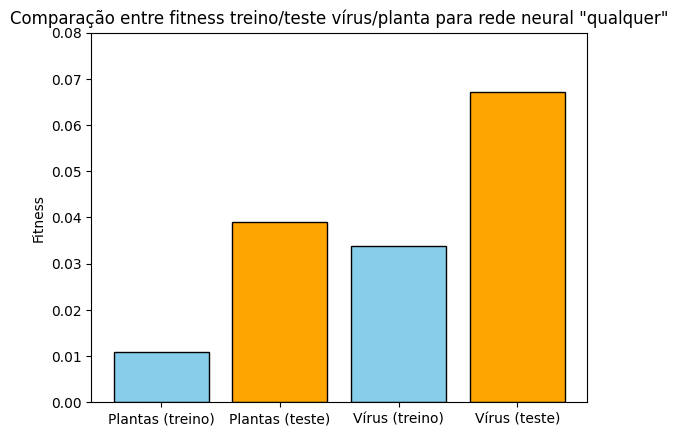

In [237]:
# Criando um gráfico de barras para comparar os valores
plt.bar(['Plantas (treino)', 'Plantas (teste)', 'Vírus (treino)', 'Vírus (teste)'], dados, color=['skyblue', 'orange'] * 2, edgecolor='black')

# Personalizando o gráfico
plt.ylabel('Fitness')
plt.title('Comparação entre fitness treino/teste vírus/planta para rede neural "qualquer"')
plt.ylim(0, 0.08)  # Ajustando o eixo y para destacar a diferença

# Exibindo o gráfico
plt.show()

In [187]:
# possíveis valores para nossa população inicial
LIM_NUM_NEURONS = 300
LIM_INF_NUM_NEURONS = 16
LIM_NUM_LAYERS = 5
LIST_ACT_FUNCS = ['leaky_relu'] #['relu', 'gelu', 'leaky_relu', 'silu']

p_neur = [i for i in range(LIM_INF_NUM_NEURONS, LIM_NUM_NEURONS+1)]
p_h_layers = [i for i in range(1, LIM_NUM_LAYERS+1)]
p_act_func = LIST_ACT_FUNCS


In [188]:
# gerando uma RN com parâmetros 'aleatórios' (dentro de opções pré definidas)

def gen_random_nn():
    layers = random.choice(p_h_layers)
    act_funcs = [random.choice(p_act_func) for _ in range(layers)]
    neur_num = [random.choice(p_neur) for _ in range(layers)]
    nn = NeuralNetwork(X_train_plants.shape[1], y_train_plants.shape[1], layers, [neur_num, act_funcs])
    return nn
        

In [189]:
# Inicialização da população
class Particle:
    def __init__(self, nn: NeuralNetwork):
        self.nn = nn
        self.position = {
            "neurons": nn.layer_features[0],
            "activation": nn.layer_features[1],
            'layers': nn.h_layer_num
        }
        self.velocity = {
            "neurons": [random.uniform(-5, 5) for _ in range(nn.h_layer_num)],
            "activation": [random.uniform(-1, 1) for _ in range(nn.h_layer_num)],
            'layers': random.uniform(-1, 1)
        }
        self.best_position = deepcopy(self.position)
        self.best_loss = float("inf")
        self.current_loss = float("inf")

# Função para atualizar a posição e velocidade de cada partícula
def update_particle(particle, global_best_position, w=0.5, c1=1.5, c2=1.5):

    r1, r2 = random.random(), random.random()
    particle.velocity['layers'] = (
            w * particle.velocity["layers"]
            + c1 * r1 * (particle.best_position["layers"] - particle.position["layers"])
            + c2 * r2 * (global_best_position["layers"] - particle.position["layers"])
        )
    particle.position['layers'] = max(
        1, min(LIM_NUM_LAYERS, round(particle.position["layers"] + particle.velocity["layers"]))
    )

    for i in range(particle.nn.h_layer_num):
        # Atualizar velocidade
        r1, r2 = random.random(), random.random()
        particle.velocity["neurons"][i] = (
            w * particle.velocity["neurons"][i]
            + c1 * r1 * ((0 if i >= len(particle.best_position['neurons']) else particle.best_position["neurons"][i]) - particle.position["neurons"][i])
            + c2 * r2 * ((0 if i >= len(global_best_position['neurons']) else global_best_position["neurons"][i]) - particle.position["neurons"][i])
        )
        # Atualizar posição (respeitando os limites)
        particle.position["neurons"][i] = max(
            LIM_INF_NUM_NEURONS, min(LIM_NUM_NEURONS, round(particle.position["neurons"][i] + particle.velocity["neurons"][i]))
        )

    # Ajustar funções de ativação com base na vizinhança
    for i in range(len(particle.position["activation"])):
        # particle.velocity["activation"][i] += (w * random.uniform(-1, 1) + c1 * r1 - c2 * r2)
        particle.position["activation"][i] = random.choice(p_act_func)
    
    dif = particle.position['layers'] - particle.nn.h_layer_num

    if dif > 0:
        for i in range(dif):
            particle.position['neurons'].append(LIM_INF_NUM_NEURONS)
            particle.velocity['neurons'].append(random.uniform(-5, 5))
            particle.position['activation'].append(random.choice(p_act_func))
            particle.velocity['activation'].append(random.uniform(-1, 1))
    elif dif < 0:
        for i in range(-dif):
            particle.position['neurons'].pop()
            particle.velocity['neurons'].pop()
            particle.position['activation'].pop()
            particle.velocity['activation'].pop()
            
        

# Avaliação do fitness (Hamming Loss)
def evaluate_fitness(particle, X_train, y_train, X_test, y_test):
    print(f'My particle will have position={particle.position}')
    print(f'Its nn layer features before were {particle.nn.layer_features}')
    particle.nn.layer_features = [
        particle.position["neurons"],
        particle.position["activation"]
    ]
    particle.nn.create_model()
    particle.nn.train_model(X_train, y_train, epochs=50, batch=32, val_split=0.3)
    particle.nn.model_loss(X_test, y_test)
    particle.current_loss = particle.nn.hamming_loss

    # Atualizar melhor posição
    if particle.current_loss < particle.best_loss:
        particle.best_loss = particle.current_loss
        particle.best_position = particle.position

In [190]:

# Função principal para o PSO
def pso_algorithm(X_train, y_train, X_test, y_test, topology_graph, population_size=12, generations=10):
    # Gerar população inicial
    population = [Particle(gen_random_nn()) for _ in range(population_size)]
    global_best_loss = float("inf")
    global_best_position = None

    generation_bests = []
    every_particle_stats = []

    for generation in range(generations):
        print(f"Geração {generation + 1}/{generations}")
        fitnesses_and_pos = []
        best_of_gen = float('inf')
        best_of_gen_pos = None

        for particle in population:
            evaluate_fitness(particle, X_train, y_train, X_test, y_test)
            fitnesses_and_pos.append((particle.current_loss, deepcopy(particle.position)))

            # Atualizar melhor global
            if particle.current_loss < global_best_loss:
                global_best_loss = particle.current_loss
                global_best_position = deepcopy(particle.position)
            
            if particle.current_loss < best_of_gen:
                best_of_gen = particle.current_loss
                best_of_gen_pos = deepcopy(particle.position)
        
        every_particle_stats.append(fitnesses_and_pos)
        print(fitnesses_and_pos)
        # Atualizar partículas
        for i, particle in enumerate(population):
            neigs = topology_graph[i]
            melhor_fit, melhor_fit_pos = fitnesses_and_pos[i]
            print(i, neigs, melhor_fit, melhor_fit_pos)
            for neig in neigs:
                if fitnesses_and_pos[neig][0] < melhor_fit:
                    melhor_fit, melhor_fit_pos = fitnesses_and_pos[neig]
            update_particle(particle, melhor_fit_pos)

        #for particle in population:
        #    update_particle(particle, global_best_position)

        print(f"Melhor Hamming Loss da geração {generation}: {global_best_loss:.4f}")
        generation_bests.append((best_of_gen, best_of_gen_pos))

    return generation_bests, every_particle_stats, global_best_loss, global_best_position

In [191]:
pop_size = 12
ring_graph = [[(i-1) % pop_size, (i+1) % pop_size] for i in range(pop_size)]

In [192]:
gen_bests_ring, every_part_bests_ring, global_best_ring, global_best_pos_ring = pso_algorithm(X_train_plants, y_train_plants, X_test_plants, y_test_plants, ring_graph, population_size=pop_size, generations=20)

Geração 1/20
My particle will have position={'neurons': [156], 'activation': ['leaky_relu'], 'layers': 1}
Its nn layer features before were [[156], ['leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [127, 135, 274, 29, 117], 'activation': ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu'], 'layers': 5}
Its nn layer features before were [[127, 135, 274, 29, 117], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [65, 199, 192], 'activation': ['leaky_relu', 'leaky_relu', 'leaky_relu'], 'layers': 3}
Its nn layer features before were [[65, 199, 192], ['leaky_relu', 'leaky_relu', 'leaky_relu']]
10/10 [==============================] - 0s 1ms/step
My particle will have position={'neurons': [164, 56, 135, 67, 210], 'activation': ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu'

In [193]:
every_graph = [[] for _ in range(pop_size)]

for i in range(pop_size):
    for j in range(len(every_part_bests_ring)):
        every_graph[i].append(every_part_bests_ring[j][i][0])

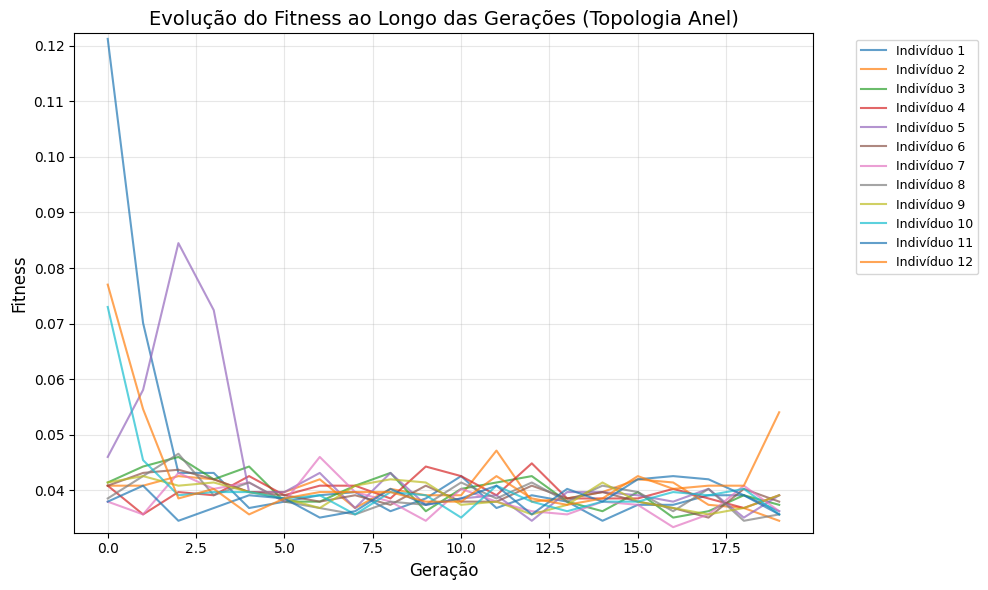

In [215]:
num_generations = len(every_part_bests_ring)
plt.figure(figsize=(10, 6))  # Define o tamanho da figura

for i in range(pop_size):
    plt.plot(range(num_generations), every_graph[i], label=f"Indivíduo {i + 1}", alpha=0.7)

# Ajustar eixos
plt.xlabel("Geração", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.title("Evolução do Fitness ao Longo das Gerações (Topologia Anel)", fontsize=14)
plt.grid(alpha=0.3)

# Opção: Ajustar o eixo y para destacar os valores próximos
plt.ylim([min(min(row) for row in every_graph) - 0.001, max(max(row) for row in every_graph) + 0.001])

# Legenda
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

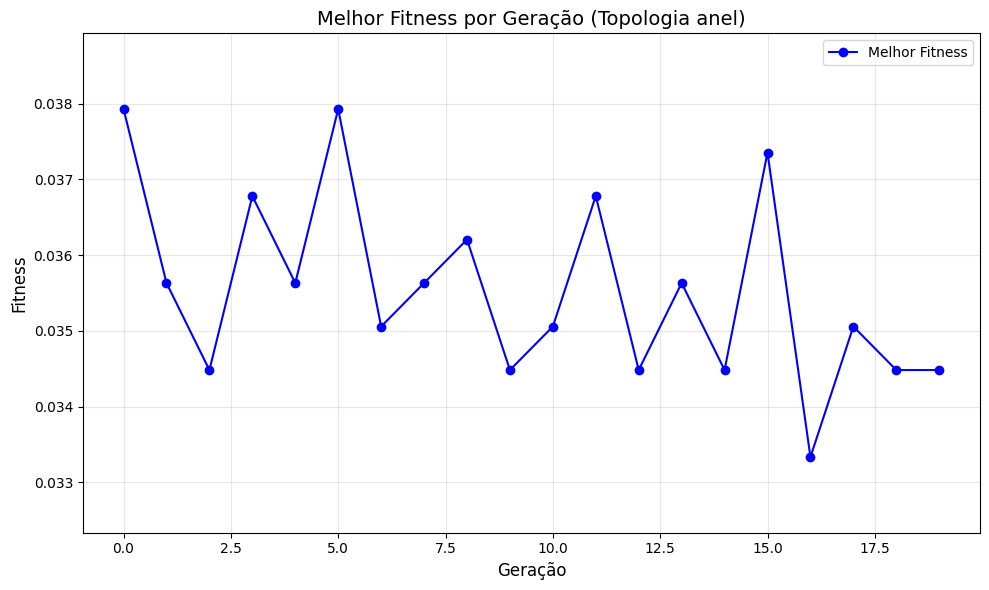

In [216]:
# Supondo que você já tenha a lista gen_bests
# Extrair o fitness (primeiro elemento) de cada tupla
best_fitness_per_generation = [generation[0] for generation in gen_bests_ring]

# Número de gerações
num_generations = len(best_fitness_per_generation)

# Criar o gráfico
plt.figure(figsize=(10, 6))  # Define o tamanho da figura

# Plotar o melhor fitness por geração
plt.plot(range(num_generations), best_fitness_per_generation, marker='o', color='b', label="Melhor Fitness")

# Ajustar eixos
plt.xlabel("Geração", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.title("Melhor Fitness por Geração (Topologia anel)", fontsize=14)
plt.grid(alpha=0.3)

# Opção: Ajustar o eixo y (valores muito próximos)
plt.ylim([min(best_fitness_per_generation) - 0.001, max(best_fitness_per_generation) + 0.001])

# Legenda
plt.legend(fontsize=10)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [196]:
global_topology = [[j for j in range(pop_size) if j != i] for i in range(pop_size)]

In [197]:
gen_bests_globaltopo, every_part_bests_globaltopo, global_best_globaltopo, global_best_pos_globaltopo = pso_algorithm(X_train_plants, y_train_plants, X_test_plants, y_test_plants, global_topology, population_size=pop_size, generations=20)

Geração 1/20
My particle will have position={'neurons': [213, 147, 292, 160, 28], 'activation': ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu'], 'layers': 5}
Its nn layer features before were [[213, 147, 292, 160, 28], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [69, 121, 291, 238, 52], 'activation': ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu'], 'layers': 5}
Its nn layer features before were [[69, 121, 291, 238, 52], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [24, 215, 76, 289], 'activation': ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu'], 'layers': 4}
Its nn layer features before were [[24, 215, 76, 289], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
10/10 [=============

In [198]:
every_graph_global = [[] for _ in range(pop_size)]

for i in range(pop_size):
    for j in range(len(every_part_bests_globaltopo)):
        every_graph_global[i].append(every_part_bests_globaltopo[j][i][0])

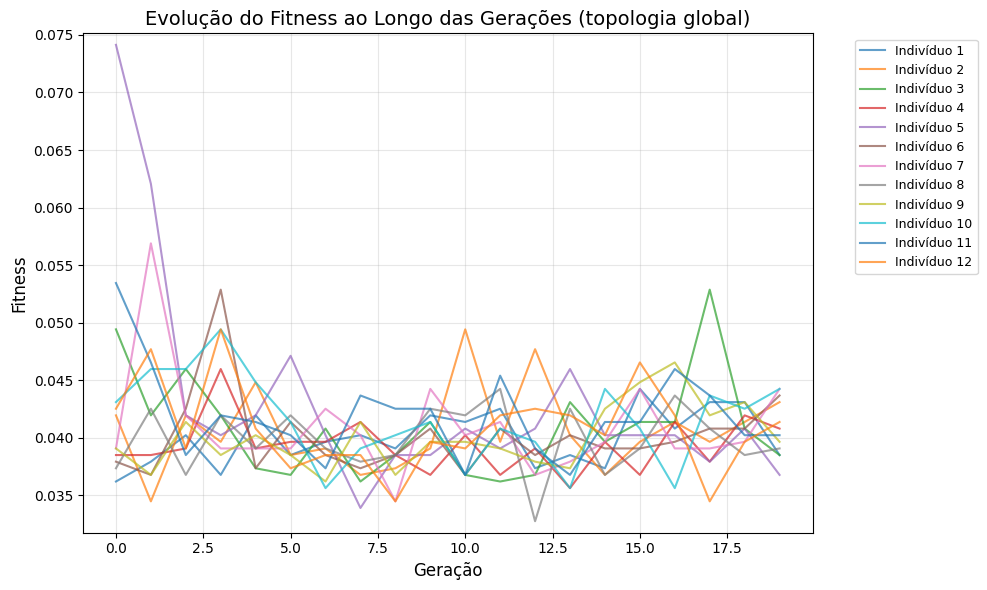

In [199]:
num_generations = len(every_part_bests_globaltopo)
plt.figure(figsize=(10, 6))  # Define o tamanho da figura

for i in range(pop_size):
    plt.plot(range(num_generations), every_graph_global[i], label=f"Indivíduo {i + 1}", alpha=0.7)

# Ajustar eixos
plt.xlabel("Geração", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.title("Evolução do Fitness ao Longo das Gerações (topologia global)", fontsize=14)
plt.grid(alpha=0.3)

# Opção: Ajustar o eixo y para destacar os valores próximos
plt.ylim([min(min(row) for row in every_graph_global) - 0.001, max(max(row) for row in every_graph_global) + 0.001])

# Legenda
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

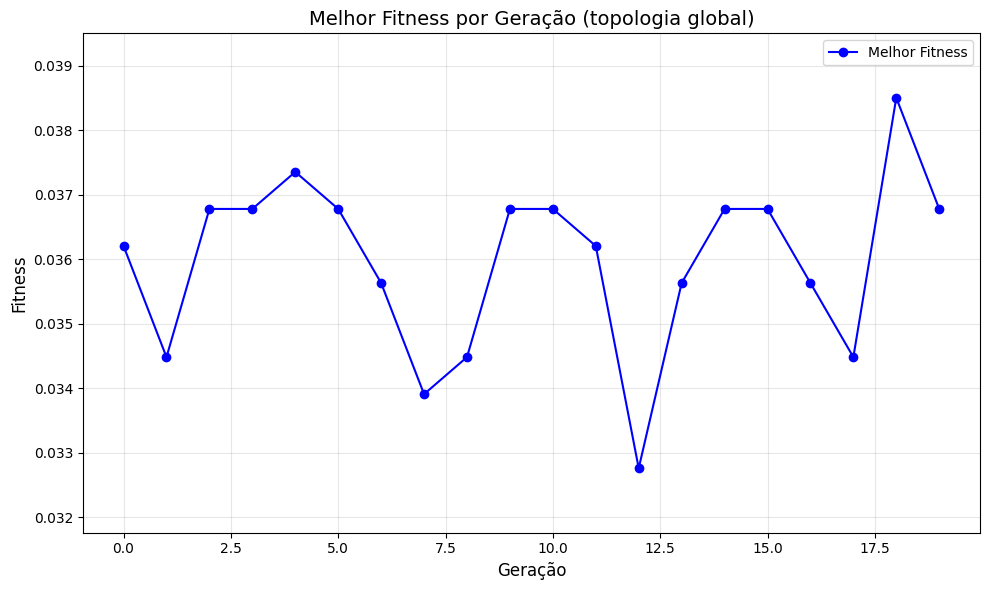

In [200]:
# Supondo que você já tenha a lista gen_bests
# Extrair o fitness (primeiro elemento) de cada tupla
best_fitness_per_generation = [generation[0] for generation in gen_bests_globaltopo]

# Número de gerações
num_generations = len(best_fitness_per_generation)

# Criar o gráfico
plt.figure(figsize=(10, 6))  # Define o tamanho da figura

# Plotar o melhor fitness por geração
plt.plot(range(num_generations), best_fitness_per_generation, marker='o', color='b', label="Melhor Fitness")

# Ajustar eixos
plt.xlabel("Geração", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.title("Melhor Fitness por Geração (topologia global)", fontsize=14)
plt.grid(alpha=0.3)

# Opção: Ajustar o eixo y (valores muito próximos)
plt.ylim([min(best_fitness_per_generation) - 0.001, max(best_fitness_per_generation) + 0.001])

# Legenda
plt.legend(fontsize=10)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [219]:
"""  
Van neumann

0 1 2 3
4 5 6 7
8 9 10 11

linha i, coluna j --> id 4i+j

"""

def pega_id_viz(i, j):
    vizs = []
    for ii in range(3):
        for jj in range(4):
            if abs(i-ii) + abs(j-jj) == 1:
                vizs.append(4*ii+jj)
    return vizs

van_neumann_graph = [pega_id_viz(i, j) for i in range(3) for j in range(4)]

In [221]:
gen_bests_van_neumanntopo, every_part_bests_van_neumanntopo, global_best_van_neumanntopo, global_best_pos_van_neumanntopo = pso_algorithm(X_train_plants, y_train_plants, X_test_plants, y_test_plants, van_neumann_graph, population_size=pop_size, generations=20)

Geração 1/20
My particle will have position={'neurons': [293], 'activation': ['leaky_relu'], 'layers': 1}
Its nn layer features before were [[293], ['leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [171], 'activation': ['leaky_relu'], 'layers': 1}
Its nn layer features before were [[171], ['leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [66, 250, 111, 129], 'activation': ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu'], 'layers': 4}
Its nn layer features before were [[66, 250, 111, 129], ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']]
10/10 [==============================] - 0s 2ms/step
My particle will have position={'neurons': [106, 215, 132], 'activation': ['leaky_relu', 'leaky_relu', 'leaky_relu'], 'layers': 3}
Its nn layer features before were [[106, 215, 132], ['leaky_relu', 'leaky_relu', 'leaky_relu']]
10/10 [=============================

In [222]:
every_graph_neumann = [[] for _ in range(pop_size)]

for i in range(pop_size):
    for j in range(len(every_part_bests_van_neumanntopo)):
        every_graph_neumann[i].append(every_part_bests_van_neumanntopo[j][i][0])

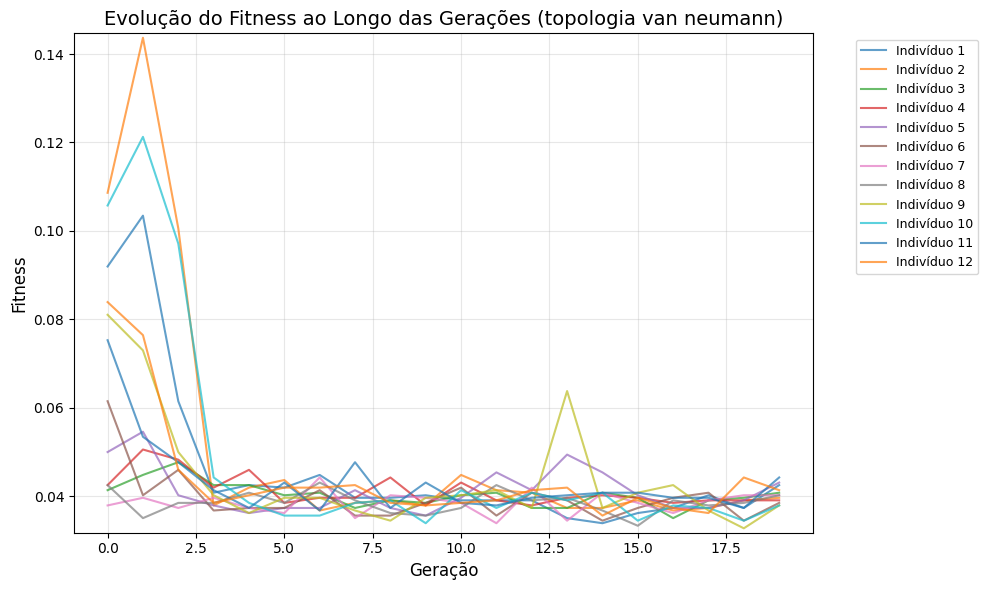

In [223]:
num_generations = len(every_part_bests_van_neumanntopo)
plt.figure(figsize=(10, 6))  # Define o tamanho da figura

for i in range(pop_size):
    plt.plot(range(num_generations), every_graph_neumann[i], label=f"Indivíduo {i + 1}", alpha=0.7)

# Ajustar eixos
plt.xlabel("Geração", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.title("Evolução do Fitness ao Longo das Gerações (topologia van neumann)", fontsize=14)
plt.grid(alpha=0.3)

# Opção: Ajustar o eixo y para destacar os valores próximos
plt.ylim([min(min(row) for row in every_graph_neumann) - 0.001, max(max(row) for row in every_graph_neumann) + 0.001])

# Legenda
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

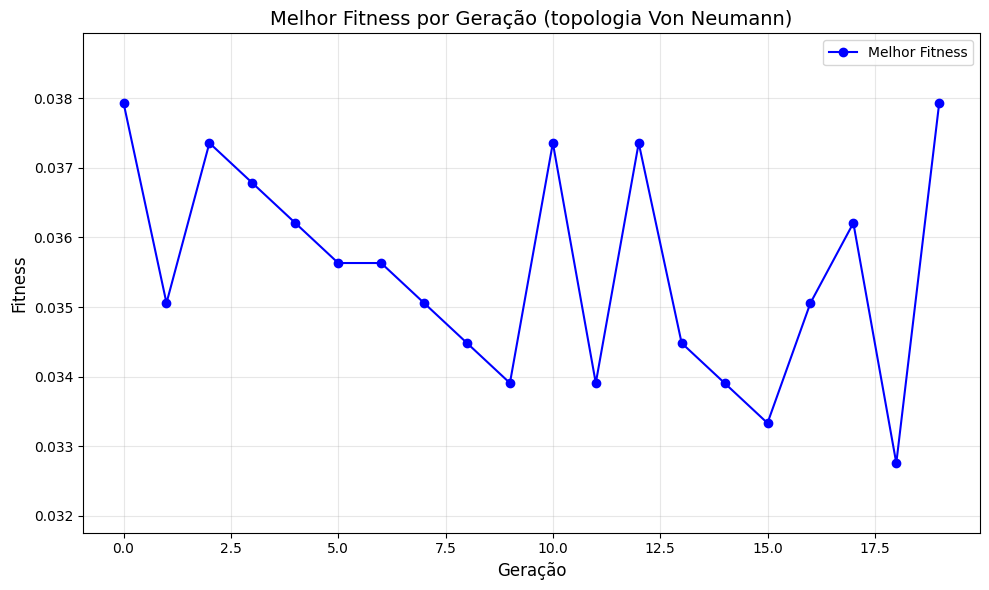

In [229]:
# Supondo que você já tenha a lista gen_bests
# Extrair o fitness (primeiro elemento) de cada tupla
best_fitness_per_generation = [generation[0] for generation in gen_bests_van_neumanntopo]

# Número de gerações
num_generations = len(best_fitness_per_generation)

# Criar o gráfico
plt.figure(figsize=(10, 6))  # Define o tamanho da figura

# Plotar o melhor fitness por geração
plt.plot(range(num_generations), best_fitness_per_generation, marker='o', color='b', label="Melhor Fitness")

# Ajustar eixos
plt.xlabel("Geração", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.title("Melhor Fitness por Geração (topologia Von Neumann)", fontsize=14)
plt.grid(alpha=0.3)

# Opção: Ajustar o eixo y (valores muito próximos)
plt.ylim([min(best_fitness_per_generation) - 0.001, max(best_fitness_per_generation) + 0.001])

# Legenda
plt.legend(fontsize=10)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

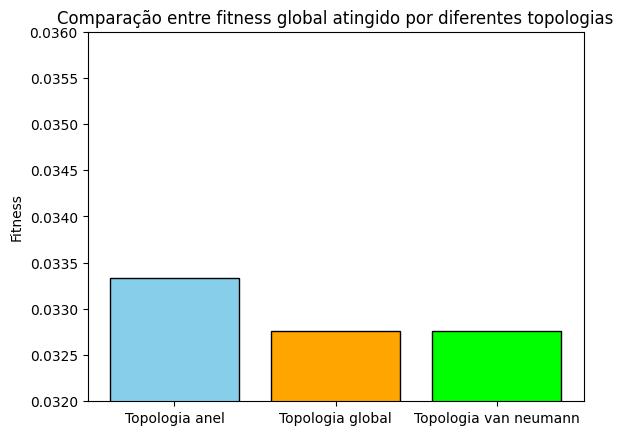

0.03333333333333333 0.032758620689655175 0.032758620689655175
{'neurons': [300, 41, 300, 16, 36], 'activation': ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu'], 'layers': 5}
{'neurons': [300, 300, 300, 16], 'activation': ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu'], 'layers': 4}


In [ ]:
# Criando um gráfico de barras para comparar os valores
plt.bar(['Topologia anel', 'Topologia global', 'Topologia van neumann'], [global_best_ring, global_best_globaltopo, global_best_van_neumanntopo], color=['skyblue', 'orange', 'lime'], edgecolor='black')

# Personalizando o gráfico
plt.ylabel('Fitness')
plt.title('Comparação entre fitness global atingido por diferentes topologias')
plt.ylim(0.032, 0.036)  # Ajustando o eixo y para destacar a diferença

# Exibindo o gráfico
plt.show()

print(global_best_ring, global_best_globaltopo, global_best_van_neumanntopo)
print(global_best_pos_globaltopo)
print(global_best_pos_van_neumanntopo)

## O que está feito -> 
Classe NeuralNetwork, que vai ser o indivíduo do nosso 
PSO

## O que precisa fazer? 
O PSO.

### Mais especificamente:

1. Gerar uma população de 12 indivíduos (existem motivos para esse número*) 
aleatórios
2. Inicializar a posição e velocidade
3. Realizar o treinamento de cada indivíduo e analisar a perda de hamming como fitness
4. Realizar a atualização da posição e velocidade de cada indivíduo
5. Voltar para 3 (posição e velocidade mudarão os parâmetros dos ind)

### Considerações sobre o algoritmo:

1. Quantas vizinhanças? Definir as vizinhanças por N de camdas? São poucos indivíduos
então seria computacionalmente barato iterar pela população
2. O split nos dados de treino e teste vai ser feito a cada geração? Um para cada
vizinhança, um para cada indivíduo?

## Quais serão nossos hiperparâmetros? 

Número de Neurônios por camada [32-256] passo de 16

Número de camadas escondidas [2-4]

Tipo da função de ativação [relu, gelu, leakyrelu, tanh]

## Considerações do que pode ser incluso como HPP

Número de Épocas

Tamanho do batch

validation split

??

